<img heigth="8" src="https://i.imgur.com/3mimh4M.png" alt="guane">

<h1 align="left">Data Science and Machine Learning</h1>

<p align="left"><i>A Data Project Template for Building Robust, Reproducible and Maintainable Predictive Solutions</i></p>

<p align="left">
  DS&ML Team | <a href="https://guane.com.co/">guane enterprises</a>
  <br>
  <b>Last updated:</b> <i>06/03/2023</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>
<p align="left">
  <a href="#introduction">Introduction</a><br>
  <a href="#1-data-adquisition">1. Data Adquisition</a><br>
  <a href="#2-exploratory-data-analysis">2. Exploratory Data Analysis</a><br>
  <a href="#3-training-models">3. Training Models</a><br>
  <br>
</p>

---

With this notebook you can test the template to develop your predictive solution.

In [1]:
import pandas as pd
import seaborn as sns
import pickle

In [2]:
import sys
sys.path.append("..")

import src
from src.utils import set_seed_everything

print(f"[INFO] Package version: {src.__version__}")

[INFO] Package version: v0.1.0


In [3]:
SEED = 20180507
set_seed_everything(SEED)

<a id="3-training-models"></a>
## 3. Training Models

We need to pre-process the data before training models. For that, we'll encode categorical features and scale numerical ones.

In [4]:
data_to_model_with = pd.read_csv("../storage/data/data_with_metadata_to_model_with.csv")

In [5]:
data_to_model_with

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,n_oses,sold_quantity_mean,site_id,cluster
0,0,179.135763,REA,classic,cross_docking,free_shipping,14.0,3,4.0,MLB,3
1,1,135.900000,REA,premium,fulfillment,free_shipping,19.0,3,8.0,MLB,3
2,2,250.304348,MEX,premium,drop_off,paid_shipping,0.0,1,1.0,MLM,3
3,3,399.000000,MEX,premium,fulfillment,free_shipping,14.0,4,2.0,MLM,3
4,4,116.233729,REA,premium,fulfillment,free_shipping,4.0,10,4.0,MLB,4
...,...,...,...,...,...,...,...,...,...,...,...
519648,660911,12.803898,REA,classic,fulfillment,paid_shipping,7.0,8,3.0,MLB,2
519649,660912,99.000000,MEX,classic,fulfillment,paid_shipping,11.0,2,7.0,MLM,2
519650,660913,141.330847,REA,premium,fulfillment,free_shipping,16.0,3,4.0,MLB,3
519651,660914,57.651017,REA,premium,fulfillment,paid_shipping,4.0,1,23.0,MLB,3


In [6]:
pd.DataFrame({
    "nan": data_to_model_with.isna().sum(),
    "dtype": data_to_model_with.dtypes,
    "nunique": data_to_model_with.nunique()
})

,nan,dtype,nunique
sku,0,int64,519653
current_price,0,float64,236893
currency,0,object,4
listing_type,0,object,2
shipping_logistic_type,0,object,3
shipping_payment,0,object,2
mean_diff,0,float64,59
n_oses,0,int64,45
sold_quantity_mean,0,float64,1347
site_id,0,object,3


In [7]:
mex_skus = data_to_model_with[data_to_model_with["currency"] == "MEX"]
mex_sq_q3 = mex_skus["sold_quantity_mean"].quantile(0.75)
mex_sq_q1 = mex_skus["sold_quantity_mean"].quantile(0.25)
mex_sq_iqr = mex_sq_q3 - mex_sq_q1

mex_cp_q3 = mex_skus["current_price"].quantile(0.75)
mex_cp_q1 = mex_skus["current_price"].quantile(0.25)
mex_cp_iqr = mex_cp_q3 - mex_cp_q1

mex_core_skus = mex_skus[
    (mex_skus["sold_quantity_mean"] < mex_sq_q3 + 1.5 * mex_sq_iqr) &
    (mex_skus["current_price"] < mex_cp_q3 + 1.5 * mex_cp_iqr)
]

mex_core_skus.describe()

,sku,current_price,mean_diff,n_oses,sold_quantity_mean,cluster
count,167295.000000,167295.000000,167295.000000,167295.000000,167295.000000,167295.000000
mean,330537.376951,271.916676,15.909328,3.284276,11.353567,2.042996
std,190557.623566,208.826122,11.800298,2.541045,9.125181,1.337729
min,2.000000,2.200000,0.000000,1.000000,1.000000,0.000000
25%,165642.500000,110.000000,8.000000,2.000000,5.000000,1.000000
50%,330586.000000,207.526441,13.000000,3.000000,8.000000,2.000000
75%,495279.000000,379.357347,20.000000,4.000000,15.000000,3.000000
max,660915.000000,969.378814,58.000000,40.000000,42.000000,4.000000


In [8]:
arg_skus = data_to_model_with[data_to_model_with["currency"] == "ARG"]
arg_sq_q3 = arg_skus["sold_quantity_mean"].quantile(0.75)
arg_sq_q1 = arg_skus["sold_quantity_mean"].quantile(0.25)
arg_sq_iqr = arg_sq_q3 - arg_sq_q1

arg_cp_q3 = arg_skus["current_price"].quantile(0.75)
arg_cp_q1 = arg_skus["current_price"].quantile(0.25)
arg_cp_iqr = arg_cp_q3 - arg_cp_q1

arg_core_skus = arg_skus[
    (arg_skus["sold_quantity_mean"] < arg_sq_q3 + 1.5 * arg_sq_iqr) &
    (arg_skus["current_price"] < arg_cp_q3 + 1.5 * arg_cp_iqr)
]

arg_core_skus.describe()

,sku,current_price,mean_diff,n_oses,sold_quantity_mean,cluster
count,35845.000000,35845.000000,35845.000000,35845.000000,35845.000000,35845.000000
mean,330508.556256,2206.326770,14.722249,3.473734,10.574111,1.974362
std,190932.028734,1990.552450,11.131949,2.539403,8.553844,1.405104
min,18.000000,8.000000,0.000000,1.000000,1.000000,0.000000
25%,165370.000000,707.542373,8.000000,2.000000,4.000000,0.000000
50%,329768.000000,1514.440678,12.000000,3.000000,8.000000,2.000000
75%,496625.000000,3259.525424,19.000000,4.000000,14.000000,3.000000
max,660887.000000,8827.118644,58.000000,45.000000,39.000000,4.000000


In [9]:
bra_skus = data_to_model_with[data_to_model_with["currency"] == "REA"]
bra_sq_q3 = bra_skus["sold_quantity_mean"].quantile(0.75)
bra_sq_q1 = bra_skus["sold_quantity_mean"].quantile(0.25)
bra_sq_iqr = bra_sq_q3 - bra_sq_q1

bra_cp_q3 = bra_skus["current_price"].quantile(0.75)
bra_cp_q1 = bra_skus["current_price"].quantile(0.25)
bra_cp_iqr = bra_cp_q3 - bra_cp_q1

bra_core_skus = bra_skus[
    (bra_skus["sold_quantity_mean"] < bra_sq_q3 + 1.5 * bra_sq_iqr) &
    (bra_skus["current_price"] < bra_cp_q3 + 1.5 * bra_cp_iqr)
]

bra_core_skus.describe()

,sku,current_price,mean_diff,n_oses,sold_quantity_mean,cluster
count,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000
mean,330230.877675,64.928126,15.124486,3.530665,9.477793,2.031059
std,190884.555611,46.717678,10.779381,2.472373,6.944181,1.373966
min,0.000000,0.890000,0.000000,1.000000,1.000000,0.000000
25%,165021.250000,29.957725,8.000000,2.000000,4.000000,1.000000
50%,330225.500000,49.570037,12.000000,3.000000,7.000000,2.000000
75%,495310.500000,85.067797,19.000000,5.000000,13.000000,3.000000
max,660914.000000,211.006949,58.000000,45.000000,32.000000,4.000000


In [10]:
core_skus = pd.concat([mex_core_skus, arg_core_skus, bra_core_skus])

In [23]:
core_skus

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,n_oses,sold_quantity_mean,site_id,cluster
2,2,250.304348,MEX,premium,drop_off,paid_shipping,0.0,1,1.0,MLM,3
3,3,399.000000,MEX,premium,fulfillment,free_shipping,14.0,4,2.0,MLM,3
5,5,571.748814,MEX,premium,fulfillment,free_shipping,25.0,1,15.0,MLM,2
6,6,490.915254,MEX,classic,fulfillment,free_shipping,22.0,2,15.0,MLM,2
9,9,224.423729,MEX,premium,fulfillment,free_shipping,51.0,1,18.0,MLM,1
...,...,...,...,...,...,...,...,...,...,...,...
519645,660907,25.262881,REA,premium,fulfillment,paid_shipping,13.0,3,3.0,MLB,4
519646,660908,28.276441,REA,premium,fulfillment,paid_shipping,12.0,5,15.0,MLB,3
519648,660911,12.803898,REA,classic,fulfillment,paid_shipping,7.0,8,3.0,MLB,2
519650,660913,141.330847,REA,premium,fulfillment,free_shipping,16.0,3,4.0,MLB,3


In [12]:
sample = core_skus.sample(50000, random_state=SEED)

In [13]:
sample

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,n_oses,sold_quantity_mean,site_id,cluster
192197,244446,102.843898,REA,classic,fulfillment,free_shipping,17.0,3,6.0,MLB,0
41433,52591,162.261017,REA,premium,fulfillment,free_shipping,19.0,3,4.0,MLB,0
112744,143350,16.900000,REA,premium,fulfillment,paid_shipping,25.0,2,7.0,MLB,2
50112,63622,95.815085,REA,premium,fulfillment,paid_shipping,19.0,2,7.0,MLB,1
391549,497945,99.000000,MEX,premium,fulfillment,paid_shipping,15.0,3,5.0,MLM,0
...,...,...,...,...,...,...,...,...,...,...,...
284604,362058,213.906780,MEX,classic,fulfillment,paid_shipping,14.0,3,7.0,MLM,1
342163,435150,48.900000,MEX,premium,cross_docking,paid_shipping,2.0,1,13.0,MLM,1
59457,75542,48.859492,REA,premium,fulfillment,paid_shipping,57.0,1,28.0,MLB,3
146406,186165,28.363559,REA,classic,fulfillment,paid_shipping,9.0,1,5.0,MLB,4


In [14]:
sample.describe()

,sku,current_price,mean_diff,n_oses,sold_quantity_mean,cluster
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000
mean,329781.60218,324.678767,15.383360,3.434420,10.33010,2.02116
std,191107.05336,830.340418,11.210776,2.520132,8.09076,1.36032
min,2.00000,1.000000,0.000000,1.000000,1.00000,0.00000
25%,164162.50000,44.759534,8.000000,2.000000,4.00000,1.00000
50%,330020.00000,98.981525,12.000000,3.000000,8.00000,2.00000
75%,495810.25000,239.000000,19.000000,4.000000,14.00000,3.00000
max,660908.00000,8821.033898,58.000000,41.000000,42.00000,4.00000


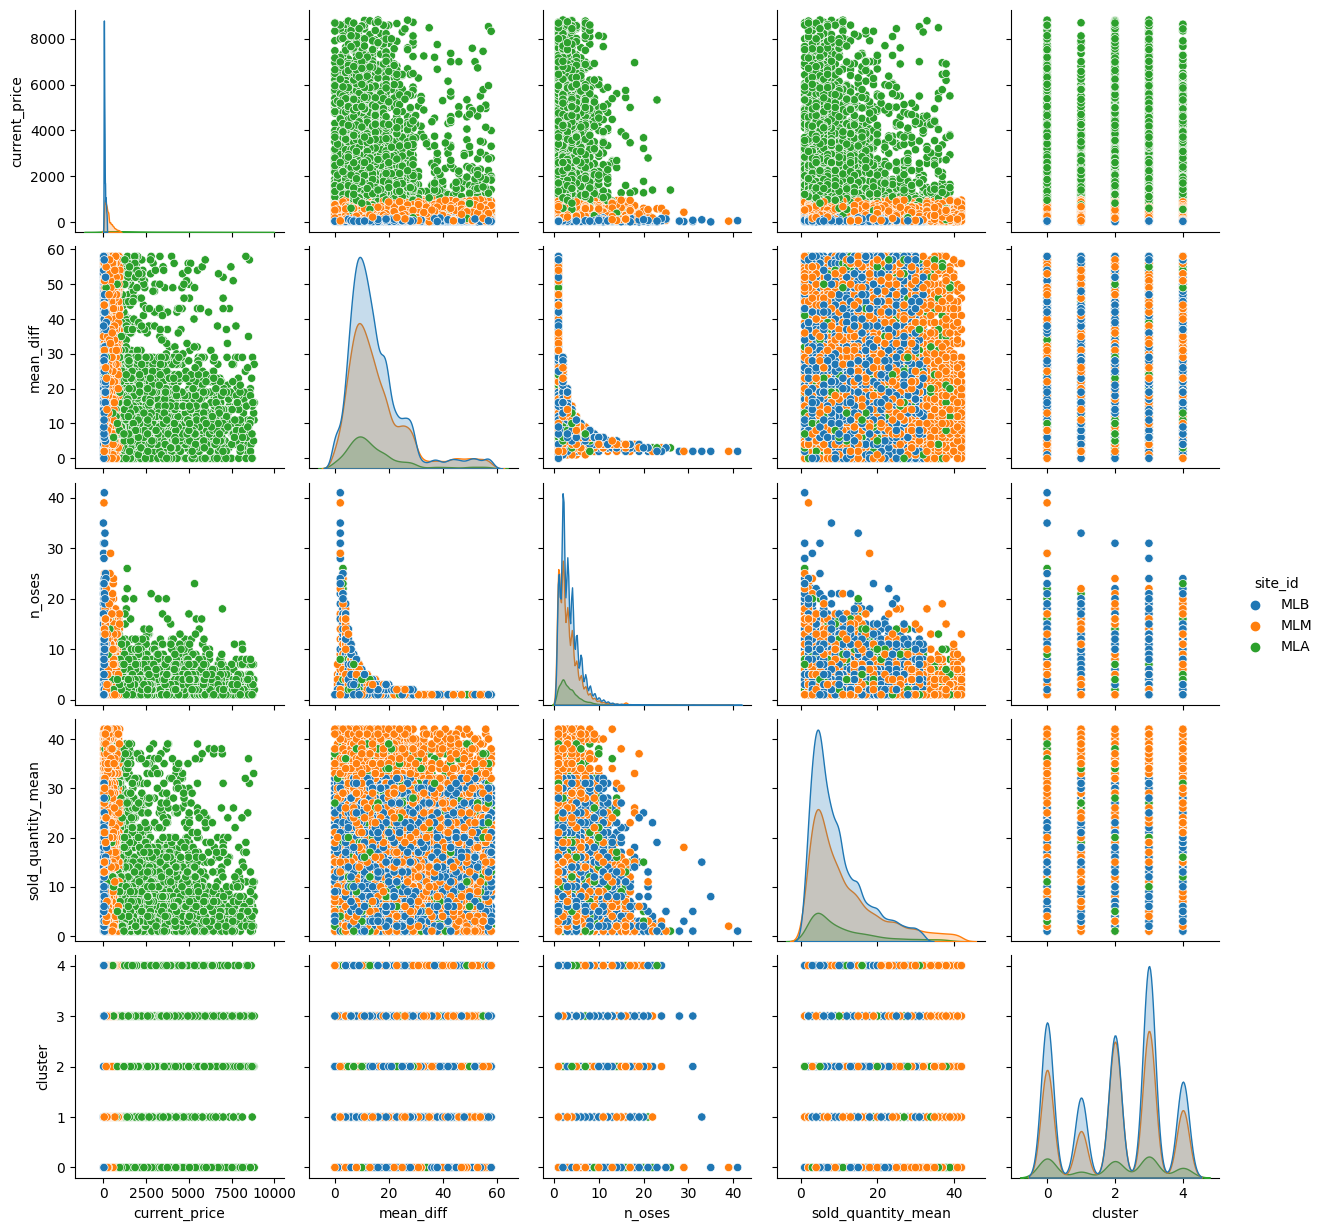

In [15]:
sns.pairplot(sample.drop(columns=["sku"]), hue="site_id")

Although the min and max values of sold quantity are similar for the three markets, the min and max values for current prince are quite different. This leads to scale with different scalers for each country.

### scaling

In [30]:
from sklearn.preprocessing import MinMaxScaler

mex_scaler = MinMaxScaler()
mex_scaled = mex_scaler.fit_transform(mex_core_skus[["sold_quantity_mean", "current_price", "n_oses"]])
mex_core_skus_scaled = mex_core_skus.drop(columns=["sold_quantity_mean", "current_price", "n_oses"])
mex_core_skus_scaled["sold_quantity_mean"] = mex_scaled[:, 0]
mex_core_skus_scaled["current_price"] = mex_scaled[:, 1]
mex_core_skus_scaled["n_oses"] = mex_scaled[:, 2]

arg_scaler = MinMaxScaler()
arg_scaled = arg_scaler.fit_transform(arg_core_skus[["sold_quantity_mean", "current_price", "n_oses"]])
arg_core_skus_scaled = arg_core_skus.drop(columns=["sold_quantity_mean", "current_price", "n_oses"])
arg_core_skus_scaled["sold_quantity_mean"] = arg_scaled[:, 0]
arg_core_skus_scaled["current_price"] = arg_scaled[:, 1]
arg_core_skus_scaled["n_oses"] = arg_scaled[:, 2]

bra_scaler = MinMaxScaler()
bra_scaled = bra_scaler.fit_transform(bra_core_skus[["sold_quantity_mean", "current_price", "n_oses"]])
bra_core_skus_scaled = bra_core_skus.drop(columns=["sold_quantity_mean", "current_price", "n_oses"])
bra_core_skus_scaled["sold_quantity_mean"] = bra_scaled[:, 0]
bra_core_skus_scaled["current_price"] = bra_scaled[:, 1]
bra_core_skus_scaled["n_oses"] = bra_scaled[:, 2]

In [31]:
with open("../storage/models/MEX_scaler.pkl", "wb") as f:
    pickle.dump(mex_scaler, f)

with open("../storage/models/ARG_scaler.pkl", "wb") as f:
    pickle.dump(arg_scaler, f)

with open("../storage/models/REA_scaler.pkl", "wb") as f:
    pickle.dump(bra_scaler, f)

In [32]:
core_skus_scaled = pd.concat([mex_core_skus_scaled, arg_core_skus_scaled, bra_core_skus_scaled])

In [33]:
core_skus_scaled

,sku,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,cluster,sold_quantity_mean,current_price,n_oses
2,2,MEX,premium,drop_off,paid_shipping,0.0,MLM,3,0.000000,0.256524,0.000000
3,3,MEX,premium,fulfillment,free_shipping,14.0,MLM,3,0.024390,0.410265,0.076923
5,5,MEX,premium,fulfillment,free_shipping,25.0,MLM,2,0.341463,0.588876,0.000000
6,6,MEX,classic,fulfillment,free_shipping,22.0,MLM,2,0.341463,0.505300,0.025641
9,9,MEX,premium,fulfillment,free_shipping,51.0,MLM,1,0.414634,0.229765,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
519645,660907,REA,premium,fulfillment,paid_shipping,13.0,MLB,4,0.064516,0.115997,0.045455
519646,660908,REA,premium,fulfillment,paid_shipping,12.0,MLB,3,0.451613,0.130339,0.090909
519648,660911,REA,classic,fulfillment,paid_shipping,7.0,MLB,2,0.064516,0.056701,0.159091
519650,660913,REA,premium,fulfillment,free_shipping,16.0,MLB,3,0.096774,0.668394,0.045455


In [34]:
enconded_core_skus = pd.get_dummies(
    core_skus_scaled,
    columns=["currency", "listing_type", "shipping_logistic_type", "shipping_payment", "site_id", "cluster"]
).drop(columns=["listing_type_classic", "shipping_payment_free_shipping"]) #We drop this columns cause their information is redundant since they're binay categories.

In [35]:
enconded_core_skus

,sku,mean_diff,sold_quantity_mean,current_price,n_oses,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,...,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping,site_id_MLA,site_id_MLB,site_id_MLM,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
2,2,0.0,0.000000,0.256524,0.000000,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,3,14.0,0.024390,0.410265,0.076923,0,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
5,5,25.0,0.341463,0.588876,0.000000,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0
6,6,22.0,0.341463,0.505300,0.025641,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
9,9,51.0,0.414634,0.229765,0.000000,0,1,0,1,0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519645,660907,13.0,0.064516,0.115997,0.045455,0,0,1,1,0,...,1,1,0,1,0,0,0,0,0,1
519646,660908,12.0,0.451613,0.130339,0.090909,0,0,1,1,0,...,1,1,0,1,0,0,0,0,1,0
519648,660911,7.0,0.064516,0.056701,0.159091,0,0,1,0,0,...,1,1,0,1,0,0,0,1,0,0
519650,660913,16.0,0.096774,0.668394,0.045455,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0


<Axes: >

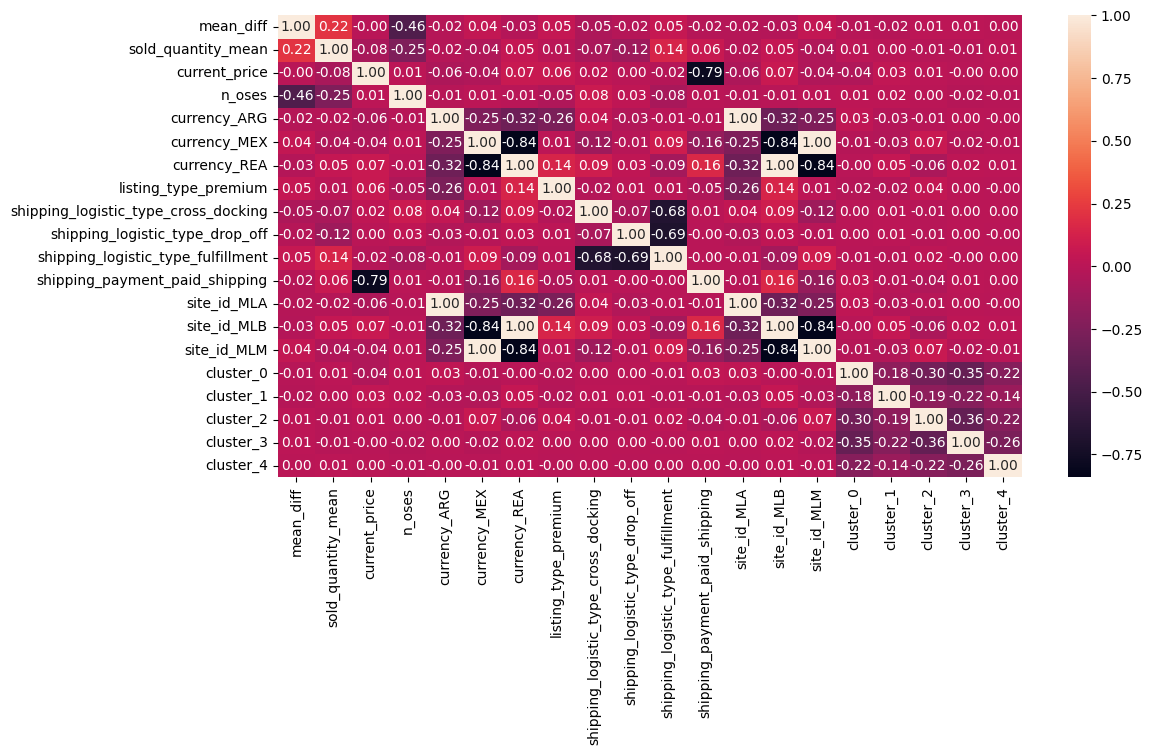

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(enconded_core_skus.drop(columns=["sku"]).corr(), annot=True, fmt=".2f")

First, note that site_id and currency represent the same information, so we'll rule out site_id.
On the other hand, our target variable (mean_diff) is not significantly correlated with any of the inputs. This already tells us that our predictions are not goint to be the best and the algothym will assign very similar probability distributions no matter the product.

In [37]:
enconded_core_skus = enconded_core_skus.drop(columns=["site_id_MLA", "site_id_MLB", "site_id_MLM"])

In [38]:
#we're interested in the probabilities of an item being out of stock before 30 days since published.
enconded_core_skus["mean_diff"] = enconded_core_skus["mean_diff"].apply(lambda x: x if x <= 29 else 30)
#enconded_core_skus = enconded_core_skus[enconded_core_skus["mean_diff"] != -1]

<Axes: xlabel='index'>

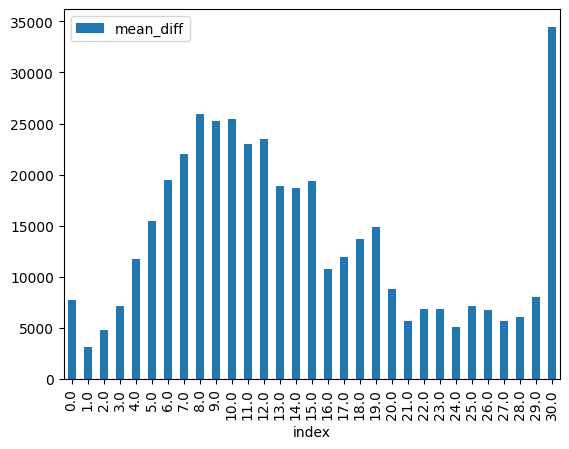

In [39]:
enconded_core_skus["mean_diff"].value_counts().reset_index().sort_values("index").plot.bar(x="index", y="mean_diff")

In [43]:
enconded_core_skus

,sku,mean_diff,sold_quantity_mean,current_price,n_oses,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
2,2,0.0,0.000000,0.256524,0.000000,0,1,0,1,0,1,0,1,0,0,0,1,0
3,3,14.0,0.024390,0.410265,0.076923,0,1,0,1,0,0,1,0,0,0,0,1,0
5,5,25.0,0.341463,0.588876,0.000000,0,1,0,1,0,0,1,0,0,0,1,0,0
6,6,22.0,0.341463,0.505300,0.025641,0,1,0,0,0,0,1,0,0,0,1,0,0
9,9,30.0,0.414634,0.229765,0.000000,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519645,660907,13.0,0.064516,0.115997,0.045455,0,0,1,1,0,0,1,1,0,0,0,0,1
519646,660908,12.0,0.451613,0.130339,0.090909,0,0,1,1,0,0,1,1,0,0,0,1,0
519648,660911,7.0,0.064516,0.056701,0.159091,0,0,1,0,0,0,1,1,0,0,1,0,0
519650,660913,16.0,0.096774,0.668394,0.045455,0,0,1,1,0,0,1,0,0,0,0,1,0


This is the shape we expect the probability distributions to follow no matter the product

In [54]:
from sklearn.model_selection import train_test_split

stratified_sample, _ = train_test_split(enconded_core_skus, test_size=0.95, stratify=enconded_core_skus['mean_diff'], random_state=42)

In [55]:
stratified_sample.shape

(21194, 18)

In [56]:
from scipy.stats import ks_2samp

population_data = enconded_core_skus['mean_diff']
sample_data = stratified_sample['mean_diff']


ks_statistic, p_value = ks_2samp(population_data, sample_data)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

KS Statistic: 4.4824006794383364e-05
P-value: 1.0


Aiming efficiency, we'll train using only a 5 percent stratified sample of the total population

In [57]:
from sklearn.model_selection import train_test_split

X_whole, y_whole = enconded_core_skus.drop(columns=["sku", "mean_diff"]), enconded_core_skus["mean_diff"]

X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole, y_whole, test_size=0.2, random_state=SEED)

X, y = stratified_sample.drop(columns=["sku", "mean_diff"]), stratified_sample["mean_diff"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [101]:
X_train.columns

Index(['sold_quantity_mean', 'current_price', 'n_oses', 'currency_ARG',
       'currency_MEX', 'currency_REA', 'listing_type_premium',
       'shipping_logistic_type_cross_docking',
       'shipping_logistic_type_drop_off', 'shipping_logistic_type_fulfillment',
       'shipping_payment_paid_shipping', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4'],
      dtype='object')

### Random Forest

In [58]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [59]:
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=max_depth, min_samples_split=min_samples_split, n_estimators=n_estimators)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring="recall_weighted").mean()
    
    return score

In [60]:
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=100)

[I 2024-07-21 15:10:31,822] A new study created in memory with name: no-name-de847a15-5ea5-472e-b402-6d44d0709a89
[I 2024-07-21 15:10:45,231] Trial 0 finished with value: 0.1992335059474408 and parameters: {'n_estimators': 653, 'max_depth': 10, 'min_samples_split': 4}. Best is trial 0 with value: 0.1992335059474408.
[I 2024-07-21 15:10:53,884] Trial 1 finished with value: 0.17676209138883578 and parameters: {'n_estimators': 293, 'max_depth': 31, 'min_samples_split': 4}. Best is trial 0 with value: 0.1992335059474408.
[I 2024-07-21 15:11:08,105] Trial 2 finished with value: 0.18785037388869416 and parameters: {'n_estimators': 540, 'max_depth': 24, 'min_samples_split': 6}. Best is trial 0 with value: 0.1992335059474408.
[I 2024-07-21 15:11:08,692] Trial 3 finished with value: 0.16455324071725883 and parameters: {'n_estimators': 17, 'max_depth': 28, 'min_samples_split': 3}. Best is trial 0 with value: 0.1992335059474408.
[I 2024-07-21 15:11:20,913] Trial 4 finished with value: 0.194692017

In [61]:
rf_best_params = rf_study.best_params
rf_best_params
#rf_best_params = {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 6}

{'n_estimators': 903, 'max_depth': 10, 'min_samples_split': 8}

In [62]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_depth=rf_best_params["max_depth"],
    min_samples_split=rf_best_params["min_samples_split"]
)
rf.fit(X_whole_train, y_whole_train)

RandomForestClassifier(max_depth=10, min_samples_split=8, n_jobs=-1,
                       random_state=42)

In [63]:
with open("../storage/models/rf_classifier_best_params.pkl", "wb") as f:
    pickle.dump(rf, f)

In [64]:
with open("../storage/models/rf_classifier_best_params.pkl", "rb") as f:
    rf = pickle.load(f)

In [65]:
rf_y_pred = rf.predict(X_whole_test)

In [66]:
print(f"Accuracy: {accuracy_score(y_whole_test, rf_y_pred)}")
print(f"Recall: {recall_score(y_whole_test, rf_y_pred, average='weighted')}")
print(f"Precision: {precision_score(y_whole_test, rf_y_pred, average='weighted', zero_division=0)}")
print(f"F1: {f1_score(y_whole_test, rf_y_pred, average='weighted')}")

Accuracy: 0.21634660753043314
Recall: 0.21634660753043314
Precision: 0.2661816316154836
F1: 0.17532113931063756


In [67]:
pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

,feature,importance
2,n_oses,0.826440
0,sold_quantity_mean,0.073140
1,current_price,0.038010
9,shipping_logistic_type_fulfillment,0.007957
6,listing_type_premium,0.007551
4,currency_MEX,0.006588
10,shipping_payment_paid_shipping,0.005594
5,currency_REA,0.005374
8,shipping_logistic_type_drop_off,0.005345
13,cluster_2,0.004480


### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
def objective_lr(trial):
    # Suggest a value for 'C'
    C = trial.suggest_float('C', 0.01, 1)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Create and train the model
    model = LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000, penalty=penalty, C=C, solver='saga')
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring="recall_weighted").mean()
    
    return score

In [70]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-07-21 15:37:47,440] A new study created in memory with name: no-name-ffc7599d-005b-4c27-8abc-c1a547230148
[I 2024-07-21 15:37:50,045] Trial 0 finished with value: 0.13913328882411632 and parameters: {'C': 0.928000876398033, 'penalty': 'l2'}. Best is trial 0 with value: 0.13913328882411632.
[I 2024-07-21 15:37:51,848] Trial 1 finished with value: 0.13347116913590126 and parameters: {'C': 0.4588364368042338, 'penalty': 'l2'}. Best is trial 0 with value: 0.13913328882411632.
[I 2024-07-21 15:38:14,196] Trial 2 finished with value: 0.15299346192080357 and parameters: {'C': 0.20486711373726635, 'penalty': 'l1'}. Best is trial 2 with value: 0.15299346192080357.
[I 2024-07-21 15:38:16,433] Trial 3 finished with value: 0.13618431316020493 and parameters: {'C': 0.6463383357133036, 'penalty': 'l2'}. Best is trial 2 with value: 0.15299346192080357.
[I 2024-07-21 15:39:16,410] Trial 4 finished with value: 0.15847853828759073 and parameters: {'C': 0.9057080536845076, 'penalty': 'l1'}. Best 

In [71]:
lr_best_params = study_lr.best_params
lr_best_params
#lr_best_params = {'C': 0.2272767613255496, 'penalty': 'l1'}

{'C': 0.8986769339804307, 'penalty': 'l1'}

In [72]:
lr = LogisticRegression(
    random_state=42,
    n_jobs=-1,
    max_iter=1000,
    penalty=lr_best_params["penalty"],
    C=lr_best_params["C"],
    solver='saga'
)

lr.fit(X_whole_train, y_whole_train)

LogisticRegression(C=0.8986769339804307, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')

In [73]:
with open("../storage/models/logistic_regression_best_params.pkl", "wb") as f:
    pickle.dump(lr, f)

In [74]:
with open("../storage/models/logistic_regression_best_params.pkl", "rb") as f:
    lr = pickle.load(f)

In [75]:
lr_y_pred = lr.predict(X_whole_test)

In [76]:
print(f"Accuracy: {accuracy_score(y_whole_test, lr_y_pred)}")
print(f"Recall: {recall_score(y_whole_test, lr_y_pred, average='weighted')}")
print(f"Precision: {precision_score(y_whole_test, lr_y_pred, average='weighted', zero_division=0)}")
print(f"F1: {f1_score(y_whole_test, lr_y_pred, average='weighted')}")

Accuracy: 0.16436255544021894
Recall: 0.16436255544021894
Precision: 0.13255665029334004
F1: 0.11886246280878403


In [97]:
pd.DataFrame({
    "feature": X_whole.columns,
    "weight": lr.coef_[0],
    "abs_weight": abs(lr.coef_[0])
}).sort_values("abs_weight", ascending=False)

,feature,weight,abs_weight
2,n_oses,-273.701517,273.701517
0,sold_quantity_mean,-1.694814,1.694814
9,shipping_logistic_type_fulfillment,-1.543108,1.543108
4,currency_MEX,-0.948322,0.948322
1,current_price,-0.510192,0.510192
8,shipping_logistic_type_drop_off,0.319664,0.319664
11,cluster_0,0.162392,0.162392
10,shipping_payment_paid_shipping,-0.136195,0.136195
3,currency_ARG,0.084780,0.084780
12,cluster_1,0.075059,0.075059


### XG boost

In [78]:
from xgboost import XGBClassifier

In [79]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    
    model = XGBClassifier(random_state=42, n_jobs=-1, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring="recall_weighted").mean()
    
    return score



In [80]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2024-07-21 17:11:58,975] A new study created in memory with name: no-name-6b04f914-babf-418b-9c81-50bff30c02e5
[I 2024-07-21 17:12:56,953] Trial 0 finished with value: 0.14638856880408177 and parameters: {'n_estimators': 464, 'max_depth': 23, 'learning_rate': 0.856277869764491}. Best is trial 0 with value: 0.14638856880408177.
[I 2024-07-21 17:13:43,264] Trial 1 finished with value: 0.14090253228723734 and parameters: {'n_estimators': 359, 'max_depth': 23, 'learning_rate': 0.8931100288964777}. Best is trial 0 with value: 0.14638856880408177.
[I 2024-07-21 17:15:05,090] Trial 2 finished with value: 0.1645535538096688 and parameters: {'n_estimators': 692, 'max_depth': 26, 'learning_rate': 0.6817237511502972}. Best is trial 2 with value: 0.1645535538096688.
[I 2024-07-21 17:16:13,436] Trial 3 finished with value: 0.17882628877498172 and parameters: {'n_estimators': 278, 'max_depth': 32, 'learning_rate': 0.08153805128608986}. Best is trial 3 with value: 0.17882628877498172.
[I 2024-07-2

In [81]:
xg_best_params = study_xgb.best_params
xg_best_params
#xg_best_params = {'n_estimators': 13, 'max_depth': 3, 'learning_rate': 0.1226676460662968}

{'n_estimators': 13, 'max_depth': 2, 'learning_rate': 0.11837681062705112}

In [82]:
xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    max_depth=xg_best_params["max_depth"],
    learning_rate=xg_best_params["learning_rate"],
    n_estimators=xg_best_params["n_estimators"]
)

xgb.fit(X_whole_train, y_whole_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11837681062705112,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=13, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [83]:
with open("../storage/models/xgb_classifier_best_params.pkl", "wb") as f:
    pickle.dump(xgb, f)

In [84]:
with open("../storage/models/xgb_classifier_best_params.pkl", "rb") as f:
    xgb = pickle.load(f)

In [85]:
xgb_y_pred = xgb.predict(X_whole_test)

In [86]:
print(f"Accuracy: {accuracy_score(y_whole_test, xgb_y_pred)}")
print(f"Recall: {recall_score(y_whole_test, xgb_y_pred, average='weighted')}")
print(f"Precision: {precision_score(y_whole_test, xgb_y_pred, average='weighted', zero_division=0)}")
print(f"F1: {f1_score(y_whole_test, xgb_y_pred, average='weighted')}")

Accuracy: 0.225724261583467
Recall: 0.225724261583467
Precision: 0.22884938560789228
F1: 0.17237416353776067


In [87]:
pd.DataFrame({
    "feature": X_whole.columns,
    "importance": xgb.feature_importances_
}).sort_values("importance", ascending=False)

,feature,importance
2,n_oses,0.502897
9,shipping_logistic_type_fulfillment,0.273039
4,currency_MEX,0.079581
0,sold_quantity_mean,0.072975
8,shipping_logistic_type_drop_off,0.052014
6,listing_type_premium,0.018204
10,shipping_payment_paid_shipping,0.001291
1,current_price,0.000000
3,currency_ARG,0.000000
5,currency_REA,0.000000


In [88]:
rf_tmp = pd.DataFrame(rf.predict_proba(X_whole_test), columns=rf.classes_)
rf_tmp

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
0,0.001996,0.004779,0.007905,0.010412,0.018177,0.022737,0.023366,0.024968,0.034691,0.032804,...,0.016510,0.020894,0.020671,0.012514,0.019402,0.019614,0.018367,0.017946,0.026054,0.005900
1,0.002766,0.004575,0.008876,0.010332,0.017269,0.020782,0.021696,0.028522,0.031167,0.033931,...,0.010200,0.015788,0.015296,0.009746,0.015179,0.014757,0.013092,0.013773,0.019937,0.005756
2,0.003384,0.005065,0.008593,0.008409,0.016589,0.020873,0.023714,0.024858,0.034179,0.032632,...,0.025394,0.034652,0.033479,0.018640,0.034310,0.033398,0.026712,0.028019,0.036626,0.008590
3,0.003180,0.005637,0.008725,0.007871,0.017510,0.019871,0.020737,0.023164,0.031594,0.031032,...,0.024498,0.035081,0.034628,0.020039,0.037283,0.032241,0.028057,0.028522,0.039569,0.008535
4,0.002453,0.006249,0.012055,0.014556,0.021638,0.024545,0.028058,0.029684,0.041951,0.039287,...,0.010355,0.016699,0.016747,0.013964,0.020164,0.024700,0.017692,0.012994,0.018938,0.010130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84771,0.001741,0.007182,0.011636,0.013931,0.021999,0.023337,0.032303,0.027923,0.049152,0.046353,...,0.014154,0.017603,0.016458,0.008497,0.015980,0.014250,0.018120,0.014639,0.018832,0.011775
84772,0.035729,0.020670,0.024856,0.024356,0.022086,0.014341,0.021783,0.022562,0.025616,0.028545,...,0.031626,0.018632,0.014692,0.018791,0.019649,0.018838,0.010706,0.013777,0.012668,0.398626
84773,0.002695,0.007622,0.014511,0.015520,0.022194,0.032339,0.025426,0.029543,0.040500,0.039300,...,0.021446,0.032184,0.034039,0.024720,0.036130,0.032552,0.032352,0.032918,0.043417,0.009420
84774,0.003086,0.005030,0.008796,0.008458,0.017044,0.020467,0.022086,0.024877,0.032408,0.031057,...,0.027321,0.039163,0.036332,0.020152,0.037649,0.035523,0.028409,0.029665,0.041293,0.012026


In [89]:
lr_tmp = pd.DataFrame(lr.predict_proba(X_whole_test), columns=lr.classes_)
lr_tmp

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
0,1.197670e-06,0.002497,0.015538,0.016306,0.014239,0.024895,0.030156,0.039441,0.055672,0.061912,...,0.008284,0.013328,0.012715,0.007043,0.012122,0.013699,0.010338,0.013430,0.016947,4.011195e-07
1,1.185756e-06,0.002268,0.013934,0.015177,0.014777,0.022876,0.029038,0.040642,0.057024,0.060963,...,0.008285,0.014797,0.012919,0.006715,0.012062,0.012594,0.011288,0.010623,0.017362,4.410181e-07
2,6.158066e-04,0.010664,0.010828,0.006407,0.006920,0.008120,0.011471,0.016310,0.026188,0.031829,...,0.026717,0.036105,0.036417,0.023441,0.038113,0.041431,0.029823,0.029545,0.039789,7.846377e-04
3,5.694205e-04,0.012590,0.010583,0.006579,0.006305,0.009598,0.013153,0.019484,0.031283,0.033208,...,0.028872,0.033193,0.032286,0.022967,0.038572,0.032107,0.029576,0.024888,0.038400,6.947289e-04
4,9.961431e-08,0.002063,0.017946,0.020050,0.019111,0.021281,0.029820,0.039879,0.059292,0.061590,...,0.005457,0.008634,0.008716,0.006582,0.010952,0.012468,0.009284,0.007422,0.011294,5.189597e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84771,3.231610e-07,0.003416,0.023867,0.035324,0.036077,0.041165,0.051999,0.056665,0.080545,0.076887,...,0.005712,0.007738,0.008573,0.006975,0.009190,0.007083,0.007929,0.008503,0.009639,3.970263e-07
84772,4.781566e-02,0.026026,0.009591,0.003410,0.001861,0.002247,0.002607,0.003482,0.005917,0.007605,...,0.029624,0.032042,0.036468,0.034965,0.036491,0.033936,0.025619,0.035899,0.038709,3.755007e-01
84773,1.135362e-04,0.013810,0.022168,0.013981,0.009156,0.013558,0.015666,0.020543,0.032951,0.037758,...,0.021196,0.023673,0.028826,0.026978,0.034560,0.030353,0.024170,0.029459,0.033758,1.936809e-04
84774,4.712047e-04,0.010336,0.011092,0.006606,0.006067,0.009148,0.013489,0.019388,0.029558,0.032629,...,0.030339,0.038175,0.033606,0.019432,0.035279,0.032072,0.027832,0.026099,0.040342,7.448842e-04


In [90]:
xgb_tmp = pd.DataFrame(xgb.predict_proba(X_whole_test), columns=xgb.classes_)
xgb_tmp

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.014805,0.016441,0.017184,0.021894,0.025640,0.026927,0.026541,0.027126,0.031589,0.029983,...,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014805
1,0.014805,0.016441,0.017184,0.021894,0.025640,0.026927,0.026541,0.027126,0.031589,0.029983,...,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014805
2,0.014765,0.020278,0.023970,0.021836,0.025572,0.026855,0.026470,0.027053,0.030219,0.029687,...,0.034988,0.042622,0.042497,0.029508,0.044413,0.044578,0.039256,0.040043,0.050030,0.014765
3,0.014765,0.020278,0.023970,0.021836,0.025572,0.026855,0.026470,0.027053,0.030219,0.029687,...,0.034988,0.042622,0.042497,0.029508,0.044413,0.044578,0.039256,0.040043,0.050030,0.014765
4,0.014748,0.016378,0.017118,0.021810,0.025542,0.026823,0.029843,0.027460,0.031468,0.029868,...,0.014750,0.014750,0.014750,0.014750,0.014750,0.014750,0.014750,0.014750,0.014750,0.014748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84771,0.014805,0.016441,0.017184,0.021894,0.025640,0.026927,0.026541,0.027126,0.031589,0.029983,...,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014807,0.014805
84772,0.044180,0.025202,0.024989,0.026286,0.023501,0.024209,0.023870,0.024862,0.027771,0.027283,...,0.024068,0.022646,0.022913,0.024362,0.022454,0.019657,0.018915,0.020716,0.020915,0.251334
84773,0.014653,0.020124,0.023787,0.021670,0.025378,0.026651,0.026269,0.026848,0.031265,0.029676,...,0.034722,0.042299,0.042174,0.035391,0.044075,0.044239,0.038958,0.039739,0.049650,0.014653
84774,0.014765,0.020278,0.023970,0.021836,0.025572,0.026855,0.026470,0.027053,0.030219,0.029687,...,0.034988,0.042622,0.042497,0.029508,0.044413,0.044578,0.039256,0.040043,0.050030,0.014765


In [91]:
lr_tmp_graph = lr_tmp.copy().drop(columns=[30])
rf_tmp_graph = rf_tmp.copy().drop(columns=[30])
xgb_tmp_graph = xgb_tmp.copy().drop(columns=[30])

In [92]:
lr_tmp_graph.idxmax(axis=1).mean(), rf_tmp_graph.idxmax(axis=1).mean(), xgb_tmp_graph.idxmax(axis=1).mean(), y_whole_test[y_whole_test != 30].mean()

(10.239973577427573,
 11.615008964801358,
 14.654843351892046,
 12.794614565560416)

Note that our predictions tell that most of the products have the highest probability of getting out-of-stock around the days 8-9. While in reality, most products get out of stock around the days 12-13.

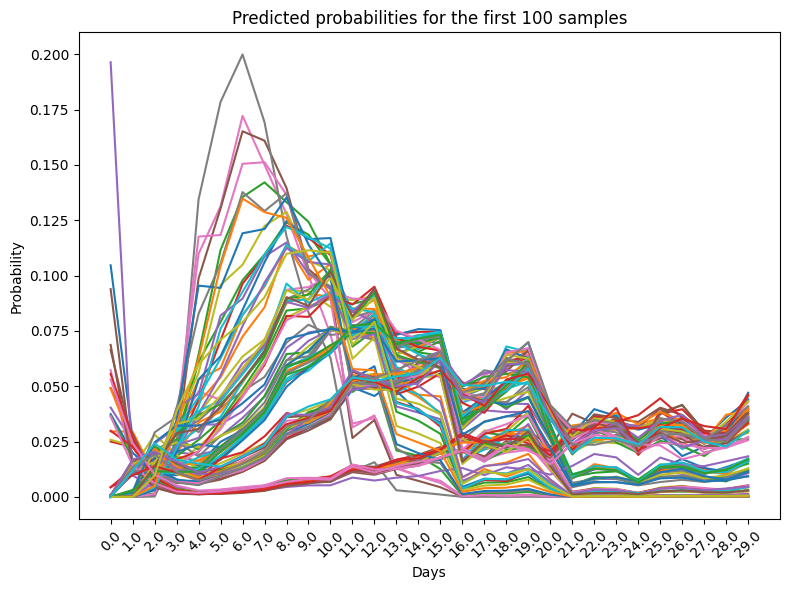

In [93]:
plt.figure(figsize=(8, 6))
for i in range(100):
    plt.plot(lr_tmp_graph.columns, lr_tmp_graph.iloc[i], label=f"sample_{i}")

plt.title("Predicted probabilities for the first 100 samples")
plt.xlabel("Days")
plt.ylabel("Probability")
plt.xticks(ticks=range(len(lr_tmp_graph.columns)), labels=lr_tmp_graph.columns, rotation=45)
plt.tight_layout()

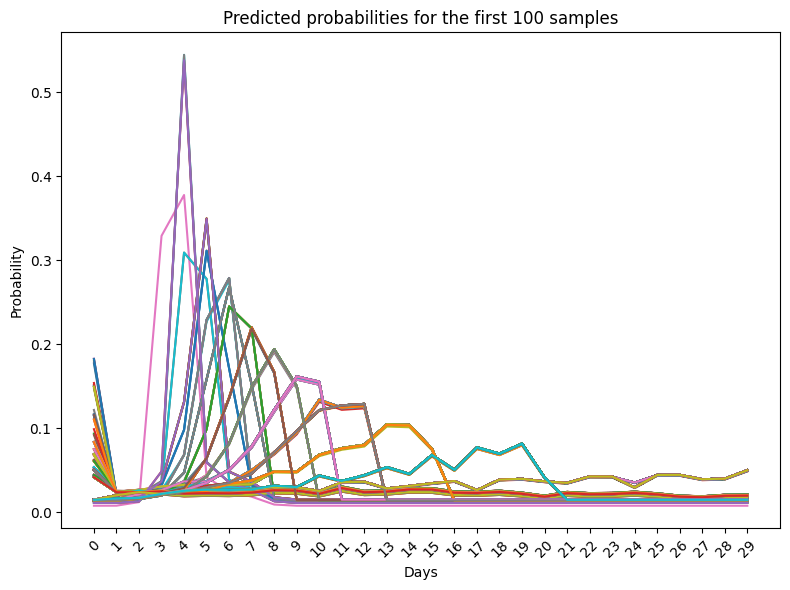

In [99]:
plt.figure(figsize=(8, 6))
for i in range(1000):
    plt.plot(xgb_tmp_graph.columns, xgb_tmp_graph.iloc[i], label=f"sample_{i}")

plt.title("Predicted probabilities for the first 100 samples")
plt.xlabel("Days")
plt.ylabel("Probability")
plt.xticks(ticks=range(len(xgb_tmp_graph.columns)), labels=xgb_tmp_graph.columns, rotation=45)
plt.tight_layout()

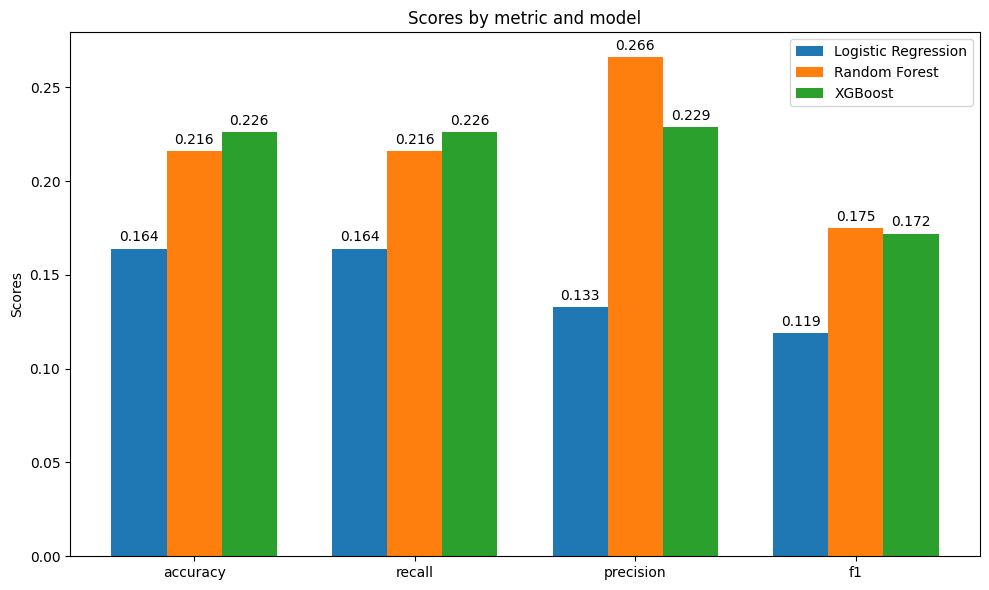

In [98]:
import numpy as np
metrics_lr = {
    "accuracy": accuracy_score(y_whole_test, lr_y_pred),
    "recall": recall_score(y_whole_test, lr_y_pred, average='weighted'),
    "precision": precision_score(y_whole_test, lr_y_pred, average='weighted', zero_division=0),
    "f1": f1_score(y_whole_test, lr_y_pred, average='weighted')
}

metrics_rf = {
    "accuracy": accuracy_score(y_whole_test, rf_y_pred),
    "recall": recall_score(y_whole_test, rf_y_pred, average='weighted'),
    "precision": precision_score(y_whole_test, rf_y_pred, average='weighted', zero_division=0),
    "f1": f1_score(y_whole_test, rf_y_pred, average='weighted')
}

metrics_xgb = {
    "accuracy": accuracy_score(y_whole_test, xgb_y_pred),
    "recall": recall_score(y_whole_test, xgb_y_pred, average='weighted'),
    "precision": precision_score(y_whole_test, xgb_y_pred, average='weighted', zero_division=0),
    "f1": f1_score(y_whole_test, xgb_y_pred, average='weighted')
}

labels = list(metrics_lr.keys())
width = 0.25
x = np.arange(len(labels))

fig, ax = plt.subplots(
    figsize=(10, 6)
)
rects1 = ax.bar(x - width, [np.round(v, 3) for v in metrics_lr.values()], width, label='Logistic Regression')
rects2 = ax.bar(x, [np.round(v, 3) for v in metrics_rf.values()], width, label='Random Forest')
rects3 = ax.bar(x + width, [np.round(v, 3) for v in metrics_xgb.values()], width, label='XGBoost')

ax.set_ylabel('Scores')
ax.set_title('Scores by metric and model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

Both models have almost the same performance. I'll take lr as default since it takes less time to predict.